In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
from ortools.linear_solver.pywraplp import Solver
from scipy.special import expit
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests


In [2]:
# Simulation parameters
MONTE_CARLO_ROUNDS = 10000

# Plot display parameters
ELO_SPACING = 20


In [3]:
# A description of result tiers and points for each tier (in a single GP leg)
tiers = ["winner", "runner-up", "semifinalist", "group runner-up", "group 3rd place", "group last"]
points = [13, 10, 7, 4, 2, 0]
max_points = max(points)

# A dict mapping tier to points received
tier_to_points = {tiers[i]: points[i] for i in range(len(tiers))}

# An array mapping index in leg standings to points received
place_to_points = [13, 10] + [7] * 2 + [4] * 4 + [2] * 4 + [0] * 4


In [4]:
name_to_rating = {
    "Ding Liren": 2799.0,
    "Levon Aronian": 2785,
    "Wesley So": 2778,
    "Shakhriyar Mamedyarov": 2771.2,
    "Anish Giri": 2772.8,
    "Richard Rapport": 2776.4,
    "Maxime Vachier-Lagrave": 2757.8,
    "Alexander Grischuk": 2742,
    "Leinier Dominguez": 2756,
    "Hikaru Nakamura": 2750,
    "Nikita Vitiugov": 2724.2,
    "Dmitry Andreikin": 2729.4,
    "Andrey Esipenko": 2723,
    "Vidit Gujrathi": 2722.6,
    "Pentala Harikrishna": 2705.2,
    "Yu Yangyi": 2710.4,
    "Daniil Dubov": 2711,
    "Vladimir Fedoseev": 2700.8,
    "Sam Shankland": 2709.2,
    "Radoslaw Wojtaszek": 2696.2,
    "Alexei Shirov": 2689.2,
    "Alexandr Predke": 2687.6,
    "Grigoriy Oparin": 2674.0,
    "Vincent Keymer": 2654.5,
    "Etienne Bacrot": 2637.8,
    "Amin Tabatabaei": 2632.4,
}
hikaru = "Hikaru Nakamura"


In [5]:
# Probabilities taken from https://chance.amstat.org/2020/09/chess/

prob_draw = lambda rwhite, rblack: expit(
    -1.627 + 0.0006955 * rwhite - 0.004668 * abs(rwhite - rblack)
)
prob_beats = lambda ra, rb: 1 / (1 + 10 ** ((rb - ra) / 400))
prob_win = lambda rwhite, rblack: prob_beats(rwhite, rblack) - prob_draw(rwhite, rblack) / 2


In [6]:
def sim_match(elo1, elo2):
    points = 0

    pdraw1 = prob_draw(elo1, elo2)
    pbeats1 = prob_beats(elo1, elo2)
    pwin1 = pbeats1 - pdraw1 / 2

    rand = random.random()
    if rand <= pwin1:
        points += 1
    elif rand > pwin1 + pdraw1:
        points -= 1

    pdraw2 = prob_draw(elo2, elo1)
    pbeats2 = prob_beats(elo2, elo1)
    pwin2 = pbeats2 - pdraw2 / 2

    rand = random.random()
    if rand <= pwin2:
        points -= 1
    elif rand > pwin2 + pdraw2:
        points += 1

    return points


def sim_group(inds, elos):
    n = len(inds)
    points = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            res = sim_match(elos[inds[i]], elos[inds[j]])
            points[i] += res
            points[j] -= res
    inds_rankings = list(sorted(range(n), key=lambda i: points[i], reverse=True))
    tiebreak = int(points[inds_rankings[0]] != points[inds_rankings[1]])
    while tiebreak == 0:
        ind0, ind1 = inds_rankings[0], inds_rankings[1]
        tiebreak = sim_match(elos[inds[ind0]], elos[inds[ind1]])
        if tiebreak < 0:
            inds_rankings[0], inds_rankings[1] = inds_rankings[1], inds_rankings[0]
    return [inds[i] for i in inds_rankings]


def sim_leg(elos, groups=None):
    n = len(elos)

    if groups is None:
        rand_inds = np.array(range(n))
        np.random.shuffle(rand_inds)
        groups = [list(g) for g in np.split(rand_inds, 4)]

    group_results = [sim_group(group, elos) for group in groups]

    rev_standings = []
    for group_place in range(3, 0, -1):
        for group_res in group_results:
            rev_standings.append(group_res[group_place])

    semis = [group_res[0] for group_res in group_results]
    semi1_res = sim_group(semis[:2], elos)
    semi2_res = sim_group(semis[2:], elos)
    rev_standings.append(semi1_res[1])
    rev_standings.append(semi2_res[1])
    finals = [semi1_res[0], semi2_res[0]]
    f_res = sim_group(finals, elos)
    rev_standings.append(f_res[1])
    rev_standings.append(f_res[0])

    leg_points = [0] * n
    for i, player in enumerate(reversed(rev_standings)):
        leg_points[player] = place_to_points[i]

    return leg_points


In [7]:
grand_prix_page = requests.get("https://www.chess.com/article/view/fide-grand-prix-2022")
grand_prix_soup = BeautifulSoup(grand_prix_page.text, "lxml")


In [8]:
# Leg 1

leg1_players_soup = grand_prix_soup.select(".standings_table")[2]
headers = []
for h in leg1_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg1_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg1_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg1_players_df = leg1_players_df.drop(["Fed"], axis=1)
leg1_players_df["Player"] = leg1_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg1_players_df["Rating"] = leg1_players_df["Player"].apply(lambda n: name_to_rating[n])

leg1_players_df["Leg 1 Points"] = pd.Series([4, 10, 2, 7, 7, 13, 4, 2, 3, 3, 2, 0, 4, 0, 0, 0])

leg1_players = leg1_players_df["Player"]

leg1_players_df


,Player,Rating,Leg 1 Points
0,Wesley So,2778.0,4
1,Levon Aronian,2785.0,10
2,Alexander Grischuk,2742.0,2
3,Richard Rapport,2776.4,7
4,Leinier Dominguez,2756.0,7
5,Hikaru Nakamura,2750.0,13
6,Andrey Esipenko,2723.0,4
7,Pentala Harikrishna,2705.2,2
8,Vidit Gujrathi,2722.6,3
9,Daniil Dubov,2711.0,3


In [9]:
# Leg 2 (simulated)

leg2_players_soup = grand_prix_soup.select(".standings_table")[5]
headers = []
for h in leg2_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg2_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg2_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg2_players_df["Player"] = leg2_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg2_players_df = leg2_players_df.drop(["Fed"], axis=1)
leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])

round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
leg2_players_df["Leg 2 Points"] = pd.Series([10, 7, 4, 0, 13, 7, 4, 0, 4, 0, 4, 2, 0, 2, 2, 2])

leg2_players = leg2_players_df["Player"]

leg2_players_df


,Player,Rating,Leg 2 Points
0,Dmitry Andreikin,2729.4,10
1,Anish Giri,2772.8,7
2,Shakhriyar Mamedyarov,2771.2,4
3,Alexander Grischuk,2742.0,0
4,Richard Rapport,2776.4,13
5,Maxime Vachier-Lagrave,2757.8,7
6,Nikita Vitiugov,2724.2,4
7,Pentala Harikrishna,2705.2,0
8,Vidit Gujrathi,2722.6,4
9,Yu Yangyi,2710.4,0


In [10]:
# Leg 3 (simulated)

leg3_players_soup = grand_prix_soup.select(".standings_table")[8]
headers = []
for h in leg3_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg3_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg3_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg3_players_df["Player"] = leg3_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg3_players_df = leg3_players_df.drop(["Fed"], axis=1)
leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])

round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

leg3_players = leg3_players_df["Player"]

leg3_players_df


,Player,Rating,Leg 3 Points
0,Anish Giri,2772.8,13
1,Wesley So,2778.0,0
2,Levon Aronian,2785.0,4
3,Shakhriyar Mamedyarov,2771.2,0
4,Maxime Vachier-Lagrave,2757.8,4
5,Leinier Dominguez,2756.0,10
6,Hikaru Nakamura,2750.0,2
7,Nikita Vitiugov,2724.2,7
8,Dmitry Andreikin,2729.4,2
9,Daniil Dubov,2711.0,7


In [11]:
def sim_grand_prix():
    leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])
    round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
    leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

    leg2_cum_df = pd.merge(leg1_players_df, leg2_players_df, on="Player", how="outer")
    final_df = pd.merge(leg2_cum_df, leg3_players_df, on="Player", how="outer")
    final_df["Rating"] = final_df["Player"].apply(lambda n: name_to_rating[n])
    final_df["Leg 1 Points"] = final_df["Leg 1 Points"].fillna(0)
    final_df["Leg 2 Points"] = final_df["Leg 2 Points"].fillna(0)
    final_df["Leg 3 Points"] = final_df["Leg 3 Points"].fillna(0)
    final_df["Total Points"] = (
        final_df["Leg 1 Points"] + final_df["Leg 2 Points"] + final_df["Leg 3 Points"]
    )
    final_df = final_df[
        ["Player", "Rating", "Leg 1 Points", "Leg 2 Points", "Leg 3 Points", "Total Points"]
    ]
    final_df = final_df.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
    final_df.index = final_df.index + 1
    return final_df


100%|██████████| 11/11 [15:07<00:00, 82.48s/it]


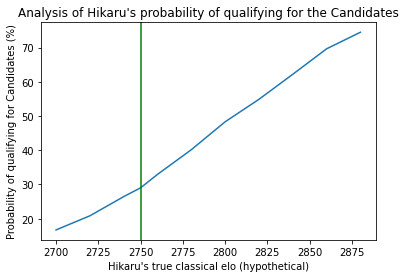

In [12]:
# Probability distribution of Hikaru candidates qualification


def prob_hikaru_qualifies(elo):
    orig_elo = name_to_rating[hikaru]
    name_to_rating[hikaru] = elo
    num_qualifies = 0
    for _ in range(MONTE_CARLO_ROUNDS):
        candidates_rows = sim_grand_prix()[:2]
        num_qualifies += int(any(row["Player"] == hikaru for _, row in candidates_rows.iterrows()))
    name_to_rating[hikaru] = orig_elo
    return num_qualifies / MONTE_CARLO_ROUNDS


hikaru_elo = np.sort(np.append(np.arange(2700, 2900, ELO_SPACING), name_to_rating[hikaru]))
candidates_prob = np.array([prob_hikaru_qualifies(elo) for elo in tqdm(hikaru_elo)])

plt.plot(hikaru_elo, candidates_prob * 100, label="Hikaru's Classical Elo (Hypothetical)")
plt.axvline(x=name_to_rating[hikaru], color="green")
plt.title("Analysis of Hikaru's probability of qualifying for the Candidates")
plt.xlabel("Hikaru's true classical elo (hypothetical)")
plt.ylabel("Probability of qualifying for Candidates (%)")
plt.savefig("hikaru_candidates_prob.png", facecolor="white")
plt.show()


In [13]:
# Average points per player

avg_final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
avg_final.index = avg_final.index + 1

print(
    f"Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
avg_final


Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is 2750):


,Player,Rating,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,Richard Rapport,2776.4,7.0,13.0,0.0000,20.0000
2,Hikaru Nakamura,2750.0,13.0,0.0,4.4190,17.4190
3,Levon Aronian,2785.0,10.0,0.0,6.0211,16.0211
4,Dmitry Andreikin,2729.4,0.0,10.0,3.7215,13.7215
5,Anish Giri,2772.8,0.0,7.0,5.4584,12.4584
6,Maxime Vachier-Lagrave,2757.8,0.0,7.0,4.8708,11.8708
7,Leinier Dominguez,2756.0,7.0,0.0,4.6704,11.6704
8,Wesley So,2778.0,4.0,0.0,5.6725,9.6725
9,Shakhriyar Mamedyarov,2771.2,0.0,4.0,5.4221,9.4221
10,Nikita Vitiugov,2724.2,0.0,4.0,3.5856,7.5856


In [14]:
# Probability of qualifying for the candidates, by player

prob_final = None

for _ in range(MONTE_CARLO_ROUNDS):
    sim = sim_grand_prix()
    if prob_final is None:
        prob_final = sim.copy(deep=True)
        prob_final["Candidates Qualification Probability (%)"] = 0
    sim.loc[:2, "num_qualified"] = 1
    sim.loc[2:, "num_qualified"] = 0
    new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
    new_prob_final["Candidates Qualification Probability (%)"] += new_prob_final["num_qualified"]
    prob_final = new_prob_final[
        ["Player", "Rating", "Candidates Qualification Probability (%)"]
    ].copy(deep=True)

prob_final["Candidates Qualification Probability (%)"] /= MONTE_CARLO_ROUNDS
prob_final["Candidates Qualification Probability (%)"] *= 100
prob_final = prob_final.sort_values(
    by="Candidates Qualification Probability (%)", ascending=False
).reset_index(drop=True)
prob_final.index = prob_final.index + 1

print(
    "Each player's probability of qualifying for the candidates "
    f"(assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
prob_final


Each player's probability of qualifying for the candidates (assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Richard Rapport,2776.4,60.16
2,Levon Aronian,2785.0,17.78
3,Hikaru Nakamura,2750.0,14.49
4,Dmitry Andreikin,2729.4,7.39
5,Maxime Vachier-Lagrave,2757.8,0.14
6,Anish Giri,2772.8,0.04
7,Vladimir Fedoseev,2700.8,0.00
8,Grigoriy Oparin,2674.0,0.00
9,Amin Tabatabaei,2632.4,0.00
10,Alexander Grischuk,2742.0,0.00


In [15]:
# Average points per place

avg_final = sim_grand_prix()

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix()
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.drop(["Player", "Rating"], axis=1)

print(f"Average points by standing position for the simulated FIDE Grand Prix:")
avg_final


Average points by standing position for the simulated FIDE Grand Prix:


,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,7.9195,8.4832,4.8810,21.2837
2,6.1700,6.4614,6.7276,19.3590
3,6.1218,3.1381,7.9576,17.2175
4,5.2549,3.2667,6.5983,15.1199
5,4.2344,3.9022,5.3278,13.4644
6,3.6584,3.7343,4.5880,11.9807
7,2.3987,4.0591,4.2665,10.7243
8,1.9283,3.9529,3.6791,9.5603
9,1.8242,3.4234,3.1414,8.3890
10,1.9654,3.2249,2.3222,7.5125
